In [4]:
import pandas as pd
import pickle
import random
import numpy as np
#Model
from gensim.models import Word2Vec
from scipy.spatial import distance
from gensim.models.doc2vec import Doc2Vec
# visualisation
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
faq_path = '../data/11-24-faq_dat_cleaned.csv'
tix_path = '../data/11-24-ticket_dat.csv'

In [3]:
ticket_dat = pd.read_csv(tix_path)
faq_dat = pd.read_csv(faq_path)

In [112]:
print(ticket_dat.shape, faq_dat.shape )
ticket_dat.fillna('', inplace=True)
faq_dat.fillna('', inplace=True)

(4250, 7) (277, 7)


In [113]:
faq_ques = list(faq_dat.question)
n_faq_ques = len(faq_ques)

faq_ans = list(faq_dat.answer_title + " " + faq_dat.answer)
n_faq_ans = len(faq_ans)

ticket_ques = list(ticket_dat.question)
n_ticket_ques = len(ticket_ques)

ticket_ans = list(ticket_dat.answer)
n_ticket_ans = len(ticket_ans)

In [114]:
with open("../code/embedding/models/doc_data/id_dict.txt", "rb") as fp:
    id_dict = pickle.load(fp)

with open("../code/embedding/models/doc_data/all_docs_prepro.txt", "rb") as fp:
    all_docs_prepro = pickle.load(fp)
    
#ticket_ans_ids = np.array(id_dict['ticket_ans'])
#all_faq_ans = id_dict['faq_ans']

model_path = '../code/embedding/models/word2vec.model'
model = Word2Vec.load(model_path)

In [115]:
list(id_dict), len(all_docs_prepro)

(['faq_ques', 'faq_ans', 'ticket_ques', 'ticket_ans'], 9054)

In [97]:
all_docs_prepro = filter(None, all_docs_prepro)
all_docs_prepro=list(all_docs_prepro)

#TODO: NEED TO UPDATE INDICES AFTER REMOVING EMPTY STRINGS

In [116]:
def doc_emb(name):
    mean_ans = np.empty((len(id_dict[name]), 128), dtype=float)
    for j in id_dict[name]:
        sentence = all_docs_prepro[j]
        words = np.empty((len(sentence), 128), dtype=float)
        for i in range(len(sentence)):
            words[i] = model[sentence[i]]
        mean_ans[j - id_dict[name][0]] = np.apply_along_axis(np.mean, 0, words)
    return mean_ans

In [117]:
#create doc vector for tickets answers i.e. average over each ticket ans the word2vec vector for each word
mean_ticket_ans = doc_emb('ticket_ans')
#create doc vector for faq ans i.e. average over each faq ans the word2vec vector for each word
mean_faq_ans = doc_emb('faq_ans')

c:\users\costanza\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [140]:
#create matrix with cosine distances from all ticket ans to all faq ans
ticket_faq_dists = np.empty((len(mean_ticket_ans), len(mean_faq_ans)), dtype=float)
for i in range(len(mean_ticket_ans)):
    for j in range(len(mean_faq_ans)):
        ticket_faq_dists[i, j] = distance.cosine(mean_ticket_ans[i], mean_faq_ans[j])

#most similar faq - ticket mapping
ticket_faq_map = np.argmin(ticket_faq_dists, axis=1)

#too big distances are set to a separate class
#big_dist = [ticket_faq_dists.min(axis=1) > 0.7]
#ticket_faq_map[big_dist] = -1  # Set all thresholded distances to have label -1

In [ ]:
#for debug
for i in range(mean_faq_ans.shape[0]):
    for j in range(mean_faq_ans.shape[1]):
        if np.isnan(mean_faq_ans[i,j]) ==True: 
            print('row {0}, column {1}'.format(i,j))

In [89]:
#for debug
for i in range(len(all_docs_prepro)):
    if not all_docs_prepro[i]:
        print(i)

# Visualization word2vec

In [141]:
temp = np.copy(ticket_faq_dists)
temp[np.isnan(ticket_faq_dists)] = 1

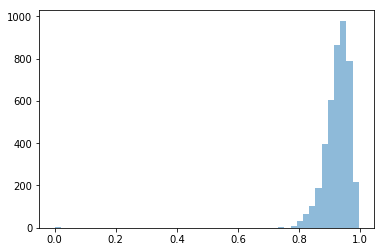

In [146]:
# take highest scoring FAQ per ticket
# plot similarity distribution
strength_FAQ_ticket = 1 - np.min(temp, axis=1)
bins =  np.linspace(0, max(strength_FAQ_ticket),50)
plt.hist(strength_FAQ_ticket, bins,alpha=.5, range=(0,1))
plt.show()

In [147]:
# some stats:
thres = np.asarray([0.5, 0.3, 0.2, 0.1])
denom = len(strength_FAQ_ticket)
print([round(np.sum(strength_FAQ_ticket>i)/denom,2) for i in thres])

[1.0, 1.0, 1.0, 1.0]


In [148]:
# VISUALISATION
FAQ_per_ticket = np.argmin(temp, axis=1)
#unique, counts = np.unique(FAQ_per_ticket, return_counts=True)

In [149]:
# creating some samples
subspace =np.nonzero(strength_FAQ_ticket<0.2)
a = random.sample(list(subspace[0]), 1)[0]
b = FAQ_per_ticket[a]

In [150]:
# Looking at samples created
print("Similarity score: ", strength_FAQ_ticket[a], '\t\t[',a,',',b,'],')
print('\nTicket: ques:\t', ticket_ques[a], '\n\ntick_ans:\t', ticket_ans[a])
#print('\n\nFAQ: ques:\t', faq_ques[b], '\n\nFAQ_ans:\t', faq_ans[b])

Similarity score:  0.0 		[ 1564 , 0 ],

Ticket: ques:	 Hi, Can you please sign the attached scr for a CACert certificate. Greetings Markus 

tick_ans:	 And this:


In [152]:
# samples in 29.11 presentation
samples = {
    50:[299, 171],
    30:[ 2613 , 12 ],
    20: [ 61 , 172 ],
    'vals': [57,31,13]
}

In [153]:
[a,b] = samples[50]

In [154]:
# allocate <50% sim to -1
med = np.median(strength_FAQ_ticket)
# to give you a feel:
print(np.median(temp), np.median(strength_FAQ_ticket))

0.27445455572741967 0.9315380892034727


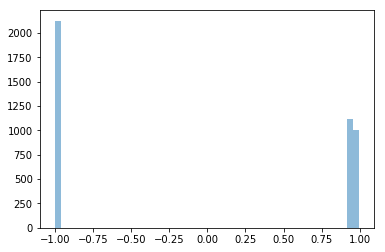

In [162]:
# try I: med over all similarities
# look at distribution
sf2t = np.copy(strength_FAQ_ticket)
sf2t[sf2t < med] = -1
f2t = np.copy(FAQ_per_ticket)
f2t[sf2t < med] = -1
bins =  np.linspace(-1, max(strength_FAQ_ticket),50)
plt.hist(sf2t, bins,alpha=.5)
plt.show()

# Visualization doc2vec

In [167]:
ticket_ans_ids = np.array(id_dict['ticket_ans'])
all_faq_ans = id_dict['faq_ans']

model_path = '../code/embedding/models/doc2vec.model'
model = Doc2Vec.load(model_path)

# Presently compute distances to all and then filter to FAQs after, specifying other_docs = all_faq_ans doesn't seem
# to work for some reason.
def sim_to_faq(doc_id):
    # Computes similarity to all faqs for a given doc_id
    dists = model.docvecs.distances(doc_id, other_docs=())
    return np.array(dists[all_faq_ans])

sim_to_faq_vec = np.vectorize(sim_to_faq, otypes=[object])

ticket_faq_dists = np.stack(sim_to_faq_vec(ticket_ans_ids)) #array w/ similarity btw each ticket_ans and each faq ans
ticket_faq_map = np.argmin(ticket_faq_dists, axis=1)

# We should threshold the distances so that if the minimum distance is not below a certain value then we assign it an
# unknown class
#big_dist = [ticket_faq_dists.min(axis=1) > 0.7]
#ticket_faq_map[big_dist] = -1 # Set all thresholded distances to have label -1
#to do: correct this assignment

Computing doc2vec Similarities...


In [168]:
temp = np.copy(ticket_faq_dists)
temp[np.isnan(ticket_faq_dists)] = 1

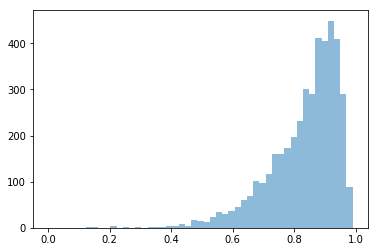

In [169]:
# take highest scoring FAQ per ticket
# plot similarity distribution
strength_FAQ_ticket = 1 - np.min(temp, axis=1)
bins =  np.linspace(0, max(strength_FAQ_ticket),50)
plt.hist(strength_FAQ_ticket, bins,alpha=.5, range=(0,1))
plt.show()

In [170]:
# some stats:
thres = np.asarray([0.5, 0.3, 0.2, 0.1])
denom = len(strength_FAQ_ticket)
print([round(np.sum(strength_FAQ_ticket>i)/denom,2) for i in thres])

[0.99, 1.0, 1.0, 1.0]


In [171]:
# VISUALISATION
FAQ_per_ticket = np.argmin(temp, axis=1)
#unique, counts = np.unique(FAQ_per_ticket, return_counts=True)

In [208]:
# creating some samples
subspace =np.nonzero(strength_FAQ_ticket<0.2)
a = random.sample(list(subspace[0]), 1)[0]
print(a)
b = FAQ_per_ticket[a]
print(b)

1564
56


In [205]:
# Looking at samples created
print("Similarity score: ", strength_FAQ_ticket[a], '\t\t[',a,',',b,'],')
print('\nTicket: ques:\t', ticket_ques[a], '\n\ntick_ans:\t', ticket_ans[a])
print('\n\nFAQ: ques:\t', faq_ques[b], '\n\nFAQ_ans:\t', faq_ans[b])

Similarity score:  0.12461877 		[ 1564 , 56 ],

Ticket: ques:	 Hi, Can you please sign the attached scr for a CACert certificate. Greetings Markus 

tick_ans:	 And this:


FAQ: ques:	 DNS problems 

FAQ_ans:	 DNS We have some problems with our DNS server at the moment. Some websites and services are not running because of this problem. Please try it again later. 


In [174]:
# samples in 29.11 presentation
samples = {
    50:[299, 171],
    30:[ 2613 , 12 ],
    20: [ 61 , 172 ],
    'vals': [57,31,13]
}

In [175]:
[a,b] = samples[50]

In [176]:
# allocate <50% sim to -1
med = np.median(strength_FAQ_ticket)
# to give you a feel:
print(np.median(temp), np.median(strength_FAQ_ticket))

0.59367746 0.8638884


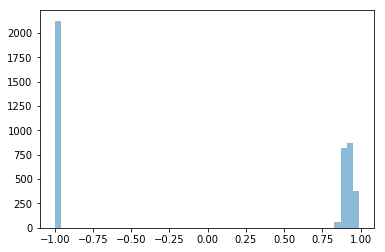

In [177]:
# try I: med over all similarities
# look at distribution
sf2t = np.copy(strength_FAQ_ticket)
sf2t[sf2t < med] = -1
f2t = np.copy(FAQ_per_ticket)
f2t[sf2t < med] = -1
bins =  np.linspace(-1, max(strength_FAQ_ticket),50)
plt.hist(sf2t, bins,alpha=.5)
plt.show()